# Vector-space models: designs, distances, basic reweighting

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2019"

## Contents

1. [Overview](#Overview)
1. [Motivation](#Motivation)
1. [Terminological notes](#Terminological-notes)
1. [Set-up](#Set-up)
1. [Matrix designs](#Matrix-designs)
1. [Pre-computed example matrices](#Pre-computed-example-matrices)
1. [Vector comparison](#Vector-comparison)
  1. [Euclidean](#Euclidean)
  1. [Length normalization](#Length-normalization)
  1. [Cosine distance](#Cosine-distance)
  1. [Matching-based methods](#Matching-based-methods)
  1. [Summary](#Summary)
1. [Distributional neighbors](#Distributional-neighbors)
1. [Matrix reweighting](#Matrix-reweighting)
  1. [Normalization](#Normalization)
  1. [Observed/Expected](#Observed/Expected)
  1. [Pointwise Mutual Information](#Pointwise-Mutual-Information)
  1. [TF-IDF](#TF-IDF)
1. [Subword information](#Subword-information)
1. [Visualization](#Visualization)
1. [Exploratory exercises](#Exploratory-exercises)

## Overview

This notebook is the first in our series about creating effective __distributed representations__. The focus is on matrix designs, assessing similarity, and methods for matrix reweighting.

The central idea (which takes some getting used to!) is that we can represent words and phrases as dense vectors of real numbers. These take on meaning by being __embedded__ in a larger matrix of representations with comparable structure.

## Motivation

Why build distributed representations? There are potentially many reasons. The two we will emphasize in this course:

1. __Understanding words in context__: There is value to linguists in seeing what these data-rich approaches can teach use about natural language lexicons, and there is value for social scientists in understanding how words are being used.

1. __Feature representations for other models__: As we will see, many models can benefit from representing examples as distributed representations.

## Terminological notes

* The distributed representations we build will always be vectors of real numbers. The models are often called __vector space models__ (VSMs).

* __Distributional representations__ are the special case where the data come entirely from co-occurrence counts in corpora. 

* We'll look at models that use supervised labels to obtain vector-based word representations. These aren't purely distributional, in that they take advantage of more than just co-occurrence patterns among items in the vocabulary, but they share the idea that words can be modeled with vectors.

* If a neural network is used to train the representations, then they might be called __neural representations__.

* The term __word embedding__ is also used for distributed representations, including distributional ones. This term is a reminder that vector representations are meaningful only when embedded in and compared with others in a unified space (usually a matrix) of representations of the same type.

* In any case, __distributed representation__ seems like the most general cover term for what we're trying to achieve, and its only downside is that sometimes people think it has something to do with distributed databases.

## Set-up

* Make sure your environment meets all the requirements for [the cs224u repository](https://github.com/cgpotts/cs224u/). For help getting set-up, see [setup.ipynb](setup.ipynb]).

* Download [the course data](http://web.stanford.edu/class/cs224u/data/data.zip), unpack it, and place it in the directory containing the course repository – the same directory as this notebook. (If you want to put it somewhere else, change `DATA_HOME` below.)

In [2]:
%matplotlib inline
import numpy as np
import os
import pandas as pd
import vsm

In [3]:
DATA_HOME = os.path.join('..', '..', 'data', 'vsmdata')
DATA_HOME

'../../data/vsmdata'

## Matrix designs

There are many, many ways to define distributional matrices. Here's a schematic overview that highlights the major decisions for building a word $\times$ word matrix:

1. Define a notion of __co-occurrence context__. This could be an entire document, a paragraph, a sentence, a clause, an NP — whatever domain seems likely to capture the associations you care about.

1. Define a __count scaling method__. The simplest method just counts everything in the context window, giving equal weight to everything inside it. A common alternative is to scale the weights based on proximity to the target word – e.g., $1/d$, where $d$ is the distance in tokens from the target.

1. Scan through your corpus building a dictionary $d$ mapping word-pairs to co-occurrence values. Every time a pair of words $w$ and $w'$ occurs in the same context (as you defined it in 1), increment $d[(w, w')]$ by whatever value is determined by your weighting scheme. You'd increment by $1$ with the weighting scheme that simply counts co-occurrences.

1. Using the count dictionary $d$ that you collected in 3, establish your full vocabulary $V$, an ordered list of words types. 
    1. For large collections of documents, $|V|$ will typically be huge. You will probably want to winnow the vocabulary at this point. 
    1. You might do this by filtering to a specific subset, or just imposing a minimum count threshold. 
    1. You might impose a minimum count threshold even if $|V|$ is small — for words with very low counts, you simply don't have enough evidence to support good representations.
    1. For words outside the vocabulary you choose, you could ignore them entirely or accumulate all their values into a designated _UNK_ vector.

1. Now build a matrix $M$ of dimension $|V| \times |V|$. Both the rows and the columns of $M$ represent words. Each cell $M[i, j]$ is filled with the value $d[(w_{1}, w_{j})]$.

## Pre-computed example matrices

The data distribution includes four matrices that we'll use for hands-on exploration. All of them were designed in the same basic way:

* They are word $\times$ word matrices with 5K rows and 5K columns. 

* The vocabulary is the top 5K most frequent unigrams.

Two come from IMDB user-supplied movie reviews, and two come from Gigaword, a collection of newswire and newspaper text. Further details:

|filename | source | window size| count weighting |
|---------|--------|------------|-----------------|
|imdb_window5-scaled.csv.gz | IMDB movie reviews | 5| 1/d |
|imdb_window20-flat.csv.gz | IMDB movie reviews | 20| 1 |
|gigaword_window5-scaled.csv.gz | Gigaword | 5 | 1/d |
|gigaword_window20-flat.csv.gz | Gigaword | 20 | 1 |

Any hunches about how these matrices might differ from each other?

In [4]:
imdb5 = pd.read_csv(
    os.path.join(DATA_HOME, 'imdb_window5-scaled.csv.gz'), index_col=0)

In [5]:
imdb20 = pd.read_csv(
    os.path.join(DATA_HOME, 'imdb_window20-flat.csv.gz'), index_col=0)

In [6]:
giga5 = pd.read_csv(
    os.path.join(DATA_HOME, 'giga_window5-scaled.csv.gz'), index_col=0)

In [7]:
giga20 = pd.read_csv(
    os.path.join(DATA_HOME, 'giga_window20-flat.csv.gz'), index_col=0)

## Explore the data

In [8]:
imdb5.head()  #5000 x 5000

,!,);,.,..,...,:),?,abandoned,abdomen,abduct,...,zebra,zero,zinc,zombie,zombies,zone,zoo,,,´
!,2.042897e+06,484.716667,5.900860e+04,2663.000000,16021.083333,1693.716667,39386.566667,23.883333,0.866667,1.083333,...,7.650000,195.350000,0.166667,361.816667,388.133333,63.733333,21.966667,605.133333,126.500000,334.600000
);,4.847167e+02,18749.933333,2.730167e+02,5.166667,60.033333,2.500000,262.900000,1.166667,0.000000,0.166667,...,0.416667,1.166667,0.000000,2.750000,3.866667,1.283333,0.500000,18.100000,1.916667,0.366667
.,5.900860e+04,273.016667,2.062572e+07,3773.166667,34080.283333,2652.766667,48404.800000,1012.583333,32.083333,27.366667,...,55.750000,1936.566667,1.583333,3994.983333,3456.016667,1220.266667,308.233333,2799.016667,733.933333,1945.400000
..,2.663000e+03,5.166667,3.773167e+03,126915.900000,1854.983333,116.250000,1700.116667,4.066667,0.000000,0.250000,...,0.250000,11.800000,0.000000,34.766667,26.516667,3.566667,2.616667,13.166667,1.983333,20.550000
...,1.602108e+04,60.033333,3.408028e+04,1854.983333,833286.266667,424.383333,10824.833333,29.616667,2.000000,0.733333,...,2.600000,79.166667,0.750000,193.150000,212.700000,45.566667,13.333333,27.350000,10.966667,168.683333


In [9]:
imdb20.head()  #5000 x 5000

,!,);,.,..,...,:),?,abandoned,abdomen,abduct,...,zebra,zero,zinc,zombie,zombies,zone,zoo,,,´
!,3576432.0,1923.0,1439432.0,36608.0,227448.0,8077.0,288507.0,567.0,29.0,21.0,...,70.0,1797.0,2.0,4906.0,4072.0,882.0,249.0,9448.0,1397.0,5326.0
);,1923.0,28134.0,10958.0,42.0,629.0,6.0,1186.0,29.0,0.0,1.0,...,2.0,19.0,0.0,31.0,44.0,19.0,5.0,520.0,76.0,4.0
.,1439432.0,10958.0,41432784.0,106174.0,859122.0,18690.0,1181266.0,15758.0,301.0,535.0,...,738.0,19894.0,34.0,52947.0,39138.0,14227.0,3356.0,105786.0,25740.0,29782.0
..,36608.0,42.0,106174.0,197480.0,37752.0,958.0,18981.0,56.0,5.0,2.0,...,4.0,141.0,1.0,469.0,290.0,69.0,28.0,313.0,71.0,292.0
...,227448.0,629.0,859122.0,37752.0,1221120.0,3468.0,131959.0,433.0,15.0,15.0,...,26.0,880.0,4.0,2654.0,2127.0,546.0,118.0,756.0,340.0,2570.0


In [10]:
giga5.head()  #5000 x 5000

,!,);,.,...,;p,</p>,<p>,?,___,abandoned,...,younger,youth,yugoslav,yugoslavia,zealand,zebra,zinc,zombie,zone,zoo
!,505797.700000,70.416667,2.222757e+04,2170.100000,0.000000,3.968388e+04,3.173778e+04,4002.300000,125.566667,9.616667,...,21.883333,27.333333,2.250000,29.466667,5.000000,0.366667,0.900000,6.716667,31.216667,7.616667
);,70.416667,82566.466667,5.458767e+03,52.783333,0.000000,5.229000e+02,3.551833e+02,107.150000,0.700000,0.166667,...,7.100000,7.116667,7.100000,20.516667,29.800000,0.400000,1.000000,0.500000,11.516667,1.250000
.,22227.566667,5458.766667,1.292838e+08,57251.566667,1.283333,2.472612e+07,1.628606e+07,91649.616667,77951.066667,6884.516667,...,11487.250000,9965.250000,9101.600000,24068.816667,18217.833333,365.216667,1102.700000,221.783333,19746.083333,3199.000000
...,2170.100000,52.783333,5.725157e+04,923609.433333,0.000000,5.747483e+04,5.099698e+04,5061.033333,294.200000,36.783333,...,40.333333,42.000000,19.633333,66.950000,39.716667,8.200000,0.666667,2.333333,79.233333,11.083333
;p,0.000000,0.000000,1.283333e+00,0.000000,360707.000000,2.883333e+01,2.125000e+01,0.333333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
giga20.head()  #5000 x 5000

,!,);,.,...,;p,</p>,<p>,?,___,abandoned,...,younger,youth,yugoslav,yugoslavia,zealand,zebra,zinc,zombie,zone,zoo
!,940195.0,702.0,621097.0,23437.0,0.0,373658.0,368544.0,59060.0,4516.0,226.0,...,592.0,597.0,191.0,197.0,145.0,14.0,11.0,52.0,944.0,159.0
);,702.0,190241.0,147684.0,288.0,0.0,31224.0,29306.0,934.0,583.0,27.0,...,105.0,80.0,116.0,214.0,424.0,5.0,15.0,5.0,111.0,13.0
.,621097.0,147684.0,305121592.0,1549023.0,1911.0,103978701.0,100660069.0,2725058.0,577519.0,118249.0,...,176762.0,141801.0,164825.0,255798.0,262532.0,4087.0,18139.0,2960.0,261561.0,38939.0
...,23437.0,288.0,1549023.0,2419985.0,0.0,862456.0,853756.0,44523.0,4486.0,413.0,...,671.0,886.0,710.0,912.0,709.0,392.0,6.0,34.0,1523.0,149.0
;p,0.0,0.0,1911.0,0.0,876993.0,347.0,412.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Vector comparison

Vector comparisons form the heart of our analyses in this context. 

* For the most part, we are interested in measuring the __distance__ between vectors. The guiding idea is that semantically related words should be close together in the vector spaces we build, and semantically unrelated words should be far apart.

* The [scipy.spatial.distance](http://docs.scipy.org/doc/scipy-0.14.0/reference/spatial.distance.html) module has a lot of vector comparison methods, so you might check them out if you want to go beyond the functions defined and explored here. Read the documentation closely, though: many of those methods are defined only for binary vectors, whereas the VSMs we'll use allow all float values.

### Euclidean

The most basic and intuitive distance measure between vectors is __euclidean distance__. The euclidean distance between two vectors $u$ and $v$ of dimension $n$ is

$$\textbf{euclidean}(u, v) = 
\sqrt{\sum_{i=1}^{n}|u_{i} - v_{i}|^{2}}$$

In two-dimensions, this corresponds to the length of the most direct line between the two points.

In `vsm.py`, the function `euclidean` just uses the corresponding [scipy.spatial.distance](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html) method to define it.

Here's the tiny vector space from the screencast on vector comparisons associated with this notebook:

In [12]:
ABC = pd.DataFrame([
    [ 2.0,  4.0], 
    [10.0, 15.0], 
    [14.0, 10.0]],
    index=['A', 'B', 'C'],
    columns=['x', 'y'])    

In [13]:
ABC

,x,y
A,2.0,4.0
B,10.0,15.0
C,14.0,10.0


In [14]:
def plot_ABC(df):
    ax = df.plot.scatter(x='x', y='y', marker='.', legend=False)
    m = df.values.max(axis=None)
    ax.set_xlim([0, m*1.2])
    ax.set_ylim([0, m*1.2])
    for label, row in df.iterrows():
        ax.text(row['x'], row['y'], label)

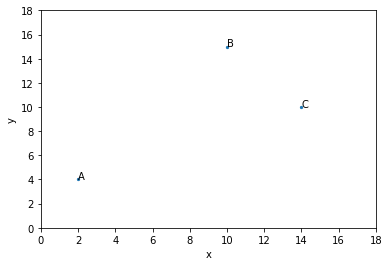

In [15]:
plot_ABC(ABC)

The euclidean distances align well with raw visual distance in the plot:

In [16]:
def abc_comparisons(df, distfunc):
    for a, b in (('A', 'B'), ('B', 'C')):
        dist = distfunc(df.loc[a], df.loc[b])
        print('{0:}({1:}, {2:}) = {3:7.02f}'.format(
            distfunc.__name__, a, b, dist))

In [17]:
abc_comparisons(ABC, vsm.euclidean)

euclidean(A, B) =   13.60
euclidean(B, C) =    6.40


However, suppose we think of the vectors as word meanings in the vector-space sense. In that case, the values don't look good: 

* The distributions of B and C are more or less directly opposed, suggesting very different meanings, whereas A and B are rather closely aligned, abstracting away from the fact that the first is far less frequent than the second. 

* In terms of the large models we will soon explore, A and B resemble a pair like _superb_ and _good_, which have similar meanings but very different frequencies. 

* In contrast, B and C are like _good_ and _disappointing_ — similar overall frequencies but different distributions with respect to the overall vocabulary.

### Length normalization

These affinities are immediately apparent if we __normalize the vectors by their length__. To do this, we first define the L2-length of a vector:

$$\|u\|_{2} = \sqrt{\sum_{i=1}^{n} u_{i}^{2}}$$

And then the normalization step just divides each value by this quantity:

$$\left[ 
  \frac{u_{1}}{\|u\|_{2}}, 
  \frac{u_{2}}{\|u\|_{2}}, 
  \ldots 
  \frac{u_{n}}{\|u\|_{2}} 
 \right]$$

In [18]:
ABC_normed = ABC.apply(vsm.length_norm, axis=1)

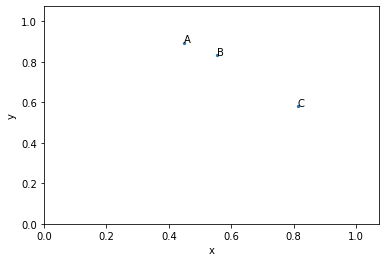

In [19]:
plot_ABC(ABC_normed)    

In [20]:
abc_comparisons(ABC_normed, vsm.euclidean)

euclidean(A, B) =    0.12
euclidean(B, C) =    0.36


Here, the connection between A and B is more apparent, as is the opposition between B and C.

### Cosine distance

Cosine distance takes overall length into account. The cosine distance between two vectors $u$ and $v$ of dimension $n$ is

$$\textbf{cosine}(u, v) = 
1 - \frac{\sum_{i=1}^{n} u_{i} \cdot v_{i}}{\|u\|_{2} \cdot \|v\|_{2}}$$

The similarity part of this (the righthand term of the subtraction) is actually measuring the angles between the two vectors. The result is the same (in terms of rank order) as one gets from first normalizing both vectors using $\|\cdot\|_{2}$ and then calculating their Euclidean distance.

In [21]:
abc_comparisons(ABC, vsm.cosine)

cosine(A, B) =    0.01
cosine(B, C) =    0.07


So, in building in the length normalization, cosine distance achieves our goal of associating A and B and separating both from C.

### Matching-based methods

Matching-based methods are also common in the literature. The basic matching measure effectively creates a vector consisting of all of the smaller of the two values at each coordinate, and then sums them:

$$\textbf{matching}(u, v) = \sum_{i=1}^{n} \min(u_{i}, v_{i})$$

This is implemented in `vsm` as `matching`.

One approach to normalizing the matching values is the [__Jaccard coefficient__](https://en.wikipedia.org/wiki/Jaccard_index). The numerator is the matching coefficient. The denominator — the normalizer — is intuitively like the set union: for binary vectors, it gives the cardinality of the union of the two being compared:

$$\textbf{jaccard}(u, v) = 
1 - \frac{\textbf{matching}(u, v)}{\sum_{i=1}^{n} \max(u_{i}, v_{i})}$$

### Summary

Suppose we set for ourselves the goal of associating A with B and disassociating B from C, in keeping with the semantic intuition expressed above. Then we can assess distance measures by whether they achieve this goal:

In [22]:
for m in (vsm.euclidean, vsm.cosine, vsm.jaccard):
    fmt = {
        'n': m.__name__,  
        'AB': m(ABC.loc['A'], ABC.loc['B']), 
        'BC': m(ABC.loc['B'], ABC.loc['C'])}
    print('{n:>15}(A, B) = {AB:5.2f} {n:>15}(B, C) = {BC:5.2f}'.format(**fmt))

      euclidean(A, B) = 13.60       euclidean(B, C) =  6.40
         cosine(A, B) =  0.01          cosine(B, C) =  0.07
        jaccard(A, B) =  0.76         jaccard(B, C) =  0.31


## Distributional neighbors

The `neighbors` function in `vsm` is an investigative aide. For a given word `w`, it ranks all the words in the vocabulary according to their distance from `w`, as measured by `distfunc` (default: `vsm.cosine`).

By playing around with this function, you can start to get a sense for how the distance functions differ. Here are some example uses; you might try some new words to get a feel for what these matrices are like and how different words look.

In [23]:
vsm.neighbors('A', ABC, distfunc=vsm.euclidean)

A     0.000000
C    13.416408
B    13.601471
dtype: float64

In [24]:
vsm.neighbors('A', ABC, distfunc=vsm.cosine)

A    0.000000
B    0.007722
C    0.116212
dtype: float64

In [25]:
vsm.neighbors('good', imdb5, distfunc=vsm.euclidean).head()

good      0.000000e+00
job       1.191396e+06
pretty    1.192212e+06
e         1.194603e+06
guys      1.194643e+06
dtype: float64

In [26]:
vsm.neighbors('good', imdb20, distfunc=vsm.euclidean).head()

good      0.000000e+00
really    1.709370e+06
great     1.746426e+06
well      1.757869e+06
story     1.760839e+06
dtype: float64

In [27]:
vsm.neighbors('good', imdb5, distfunc=vsm.cosine).head()

good       0.000000
measure    0.819398
.          0.843800
luck       0.863481
pretty     0.868561
dtype: float64

In [28]:
vsm.neighbors('good', imdb20, distfunc=vsm.cosine).head()

good       0.000000
.          0.133102
pretty     0.183657
acting     0.185801
measure    0.192544
dtype: float64

In [29]:
vsm.neighbors('good', giga5, distfunc=vsm.euclidean).head()

good      0.000000e+00
pretty    1.181946e+06
luck      1.183531e+06
et        1.183727e+06
slug      1.185593e+06
dtype: float64

In [30]:
vsm.neighbors('good', giga5, distfunc=vsm.cosine).head()

good      0.000000
.         0.862592
luck      0.881492
pretty    0.885267
</p>      0.908198
dtype: float64

In [31]:
vsm.neighbors('good', giga20, distfunc=vsm.euclidean).head()

good      0.000000e+00
that's    1.695001e+06
think     1.715627e+06
see       1.721784e+06
well      1.726043e+06
dtype: float64

In [32]:
vsm.neighbors('good', giga20, distfunc=vsm.cosine).head()

good      0.000000
.         0.102634
</p>      0.127549
<p>       0.130171
pretty    0.130454
dtype: float64

## Matrix reweighting

* The goal of reweighting is to amplify the important, trustworthy, and unusual, while deemphasizing the mundane and the quirky. 

* Absent a defined objective function, this will remain fuzzy, but the intuition behind moving away from raw counts is that frequency is a poor proxy for our target semantic ideas.

### Normalization

Normalization (row-wise or column-wise) is perhaps the simplest form of reweighting. With `vsm.length_norm`, we normalize using `vsm.vector_length`. We can also normalize each row by the sum of its values, which turns each row into a probability distribution over the columns:

$$\left[ 
  \frac{u_{1}}{\sum_{i=1}^{n}u_{i}}, 
  \frac{u_{2}}{\sum_{i=1}^{n}u_{i}}, 
  \ldots
  \frac{u_{n}}{\sum_{i=1}^{n}u_{i}}, 
\right]$$

These normalization measures are __insensitive to the magnitude of the underlying counts__. This is often a mistake in the messy world of large data sets; $[1,10]$ and $[1000,10000]$ are very different vectors in ways that will be partly or totally obscured by normalization.

### Observed/Expected

Reweighting by observed-over-expected values captures one of the central patterns in all of VSMs: we can adjust the actual cell value in a co-occurrence matrix using information from the corresponding row and column. 

In the case of observed-over-expected, the rows and columns define our expectation about what the cell value would be if the two co-occurring words were independent. In dividing the observed count by this value, we amplify cells whose values are larger than we would expect.

So that this doesn't look more complex than it is, for an $m \times n$ matrix $X$, define

$$\textbf{rowsum}(X, i) = \sum_{j=1}^{n}X_{ij}$$

$$\textbf{colsum}(X, j) = \sum_{i=1}^{m}X_{ij}$$

$$\textbf{sum}(X) = \sum_{i=1}^{m}\sum_{j=1}^{n} X_{ij}$$

$$\textbf{expected}(X, i, j) = 
\frac{
  \textbf{rowsum}(X, i) \cdot \textbf{colsum}(X, j)
}{
  \textbf{sum}(X)
}$$


Then the observed-over-expected value is

$$\textbf{oe}(X, i, j) = \frac{X_{ij}}{\textbf{expected}(X, i, j)}$$

In many contexts, it is more intuitive to first normalize the count matrix into a joint probability table and then think of $\textbf{rowsum}$ and $\textbf{colsum}$ as probabilities. Then it is clear that we are comparing the observed joint probability with what we would expect it to be under a null hypothesis of independence. These normalizations do not affect the final results, though.

Let's do a quick worked-out example. Suppose we have the count matrix $X$ = 

|          | a  | b  | rowsum |
|----------|----|----|-------|
| __x__    | 34 | 11 |  45   |
| __y__    | 47 | 7  |  54   |
|__colsum__| 81 | 18 |  99   |

Then we calculate like this:

$$\textbf{oe}(X, 1, 0) = \frac{47}{\frac{54 \cdot 81}{99}} = 1.06$$

And the full table looks like this:

|        | a    | b    | 
|--------|------|------|
| __x__  | 0.92 | 1.34 | 
| __y__  | 1.06 | 0.71 |

In [33]:
oe_ex = np.array([[ 34.,  11.], [ 47.,   7.]])

vsm.observed_over_expected(oe_ex).round(2)

array([[0.92, 1.34],
       [1.06, 0.71]])

The implementation `vsm.observed_over_expected` should be pretty efficient.

In [34]:
imdb5_oe = vsm.observed_over_expected(imdb5)

In [35]:
imdb20_oe = vsm.observed_over_expected(imdb20)

In [36]:
giga5_oe = vsm.observed_over_expected(giga5)

In [37]:
giga20_oe = vsm.observed_over_expected(giga20)

In [38]:
vsm.neighbors('good', imdb5_oe).head()

good       0.000000
.          0.716910
movie      0.791847
film       0.825658
measure    0.852617
dtype: float64

In [39]:
vsm.neighbors('good', imdb20_oe).head()

good     0.000000
.        0.081301
movie    0.083552
br       0.086846
film     0.102811
dtype: float64

In [40]:
vsm.neighbors('good', giga5_oe).head()

good      0.000000
pretty    0.904857
luck      0.909657
.         0.910456
</p>      0.917902
dtype: float64

In [41]:
vsm.neighbors('good', giga20_oe).head()

good    0.000000
one     0.327850
.       0.327980
be      0.329715
like    0.332407
dtype: float64

### Pointwise Mutual Information

Pointwise Mutual Information (PMI) is observed-over-expected in log-space:

$$\textbf{pmi}(X, i, j) = \log\left(\frac{X_{ij}}{\textbf{expected}(X, i, j)}\right)$$

This basic definition runs into a problem for $0$ count cells. The usual response is to set $\log(0) = 0$, but this is arguably confusing – cell counts that are smaller than expected get negative values, cell counts that are larger than expected get positive values, and 0-count values are placed in the middle of this ranking without real justification.

For this reason, it is more typical to use __Positive PMI__, which maps all negative PMI values to $0$:

$$\textbf{ppmi}(X, i, j) = 
\begin{cases}
\textbf{pmi}(X, i, j) & \textrm{if } \textbf{pmi}(X, i, j) > 0 \\
0 & \textrm{otherwise}
\end{cases}$$

This is the default for `vsm.pmi`.

In [42]:
# this is PPMI not PMI
imdb5_pmi = vsm.pmi(imdb5)
imdb20_pmi = vsm.pmi(imdb20)
giga5_pmi = vsm.pmi(giga5)
giga20_pmi = vsm.pmi(giga20)

In [43]:
vsm.neighbors('good', imdb5_pmi).head()

good         0.000000
decent       0.671197
bad          0.701241
great        0.723905
excellent    0.729288
dtype: float64

In [44]:
vsm.neighbors('good', imdb20_pmi).head()

good      0.000000
decent    0.487422
great     0.567846
pretty    0.570119
acting    0.588779
dtype: float64

In [45]:
vsm.neighbors('good', giga5_pmi).head()

good        0.000000
bad         0.509840
better      0.605914
pretty      0.629490
terrific    0.656493
dtype: float64

In [46]:
vsm.neighbors('good', giga20_pmi).head()

good      0.000000
really    0.256547
that's    0.258868
always    0.292188
pretty    0.293253
dtype: float64

### TF-IDF

Perhaps the best known reweighting schemes is __Term Frequency–Inverse Document Frequency (TF-IDF)__, which is, I believe, still the backbone of today's Web search technologies. As the name suggests, it is built from TF and IDF measures:

For an $m \times n$ matrix $X$:

$$\textbf{TF}(X, i, j) = \frac{X_{ij}}{\textbf{colsum}(X, i, j)}$$

$$\textbf{IDF}(X, i, j) = \log\left(\frac{n}{|\{k : X_{ik} > 0\}|}\right)$$

$$\textbf{TF-IDF}(X, i, j) = \textbf{TF}(X, i, j) \cdot \textbf{IDF}(X, i, j)$$


TF-IDF generally performs best with sparse matrices. It severely punishes words that appear in many documents; if a word appears in every document, then its IDF value is 0. As a result, it can even be problematic with verb dense word $\times$ word matrices like ours, where most words appear with most other words.

There is an implementation of TF-IDF for dense matrices in `vsm.tfidf`.

__Important__: `sklearn`'s version, [TfidfTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer), assumes that term frequency (TF) is defined row-wise and document frequency is defined column-wise. That is, it assumes `sklearn`'s document $\times$ word basic design, which makes sense for classification tasks, where the design is example $\times$ features. This is the transpose of the way we've been thinking.

## Similarity Comparison

The following table shows the five closest neighbors of the word "good" in different datasets:

|Metric|dataset|closests neighbors|
|------|-------|------------------|
|euclidean|imdb5|["job", "pretty", "e", "guys"]|
|cosine|imdb5|["good", "measure", ".", "luck", "pretty"]|
|oe|imdb5|[".", "movie", "filem", "measure"]|
|PPMI|imdb5|["decent", "bad", "great", "excellent"]|
|-------|-----|----|
|euclidean|imdb20|["really", "great", "well", "story"]|
|cosine|imdb20|[".", "pretty", "acting", "measure"]|
|oe|imdb20|[".", "movie", "br", "film"]|
|PPMI|imdb20|["decent", "great", "pretty", "acting"]|
|-------|-----|----|
|euclidean|giga5|["pretyy", "luck", "et", "slub"]|
|cosine|giga5|[".", "luck", "pretty", "< /p>"]|
|oe|giga5|["pretty", "luck", ".", "< /p>"]|
|PPMI|giga5|["bad", "better", "pretty", "terrific"]|
|-------|-----|----|
|euclidean|giga20|["that's", "think", "see", "well"]|
|cosine|giga20|[".", "< /p>", "< p>", "pretty"]|
|oe|giga20|["one", ".", "be", "like"]|
|PPMI|giga20|["really", "that's", "always", "pretty"]|
|-------|-----|----|

## Subword information

[Schütze (1993)](https://papers.nips.cc/paper/603-word-space) pioneered the use of subword information to improve representations by reducing sparsity, thereby increasing the density of connections in a VSM. In recent years, this idea has shown value in numerous contexts. 

[Bojanowski et al. (2016)](https://arxiv.org/abs/1607.04606) (the [fastText](https://fasttext.cc) team) explore a particularly straightforward approach to doing this: represent each word as the sum of the representations for the character-level n-grams it contains.

It is simple to derive character-level n-gram representations from our existing VSMs. The function `vsm.ngram_vsm` implements the basic step. Here, we create the 4-gram version of `imdb5`:

In [47]:
imdb5_ngrams = vsm.ngram_vsm(imdb5, n=4)

In [48]:
imdb5_ngrams.shape

(9806, 5000)

This has the same column dimension as the `imdb5`, but the rows are expanded with all the 4-grams, including boundary symbols `<w>` and `</w>`. Here's a simple function for creating new word representations from the associated character-level ones:

In [49]:
def character_level_rep(word, cf, n=4):
    ngrams = vsm.get_character_ngrams(word, n)
    ngrams = [n for n in ngrams if n in cf.index]    
    reps = cf.loc[ngrams].values
    return reps.sum(axis=0)    

Many variations on this are worth trying – including the original word vector where available, changing the aggregation method from `sum` to something else, using a real morphological parser instead of just n-grams, and so on.

One very powerful thing about this is that we can represent words that are not even in the original VSM:

In [50]:
'superbly' in imdb5.index

False

In [51]:
superbly = character_level_rep("superbly", imdb5_ngrams)

In [52]:
superb = character_level_rep("superb", imdb5_ngrams)

In [53]:
vsm.cosine(superb, superbly)

0.1521908156071029

## Visualization

* You can begin to get a feel for what your matrix is like by poking around with `vsm.neighbors` to see who is close to or far from whom. 

* It's very useful to complement this with the more holistic view one can get from looking at a visualization of the entire vector space. 

* Of course, any visualization will have to be much, much lower dimension than our actual VSM, so we need to proceed cautiously, balancing the high-level view with more fine-grained exploration.

* We won't have time this term to cover VSM visualization in detail. scikit-learn has a bunch of functions for doing this in [sklearn.manifold](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold), and the [user guide](http://scikit-learn.org/stable/modules/manifold.html#manifold-learning) for that package is detailed.

* It's also worth checking out the online TensorFlow [Embedding Projector tool](http://projector.tensorflow.org), which includes a fast implementation of t-SNE.

* In addition, `vsm.tsne_viz` is a wrapper around [sklearn.manifold.TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE) that handles the basic preprocessing and layout for you. t-SNE stands for [t-Distributed Stochastic Neighbor Embedding](http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf), a powerful method for visualizing high-dimensional vector spaces in 2d. See also [Multiple Maps t-SNE](https://lvdmaaten.github.io/multiplemaps/Multiple_maps_t-SNE/Multiple_maps_t-SNE.html).

/home/anwar/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anwar/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 150 missing from current font.
  font.load_char(ord(s), flags=flags)
/home/anwar/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 151 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anwar/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 151 missing from current font.
  font.load_char(ord(s), flags=flags)


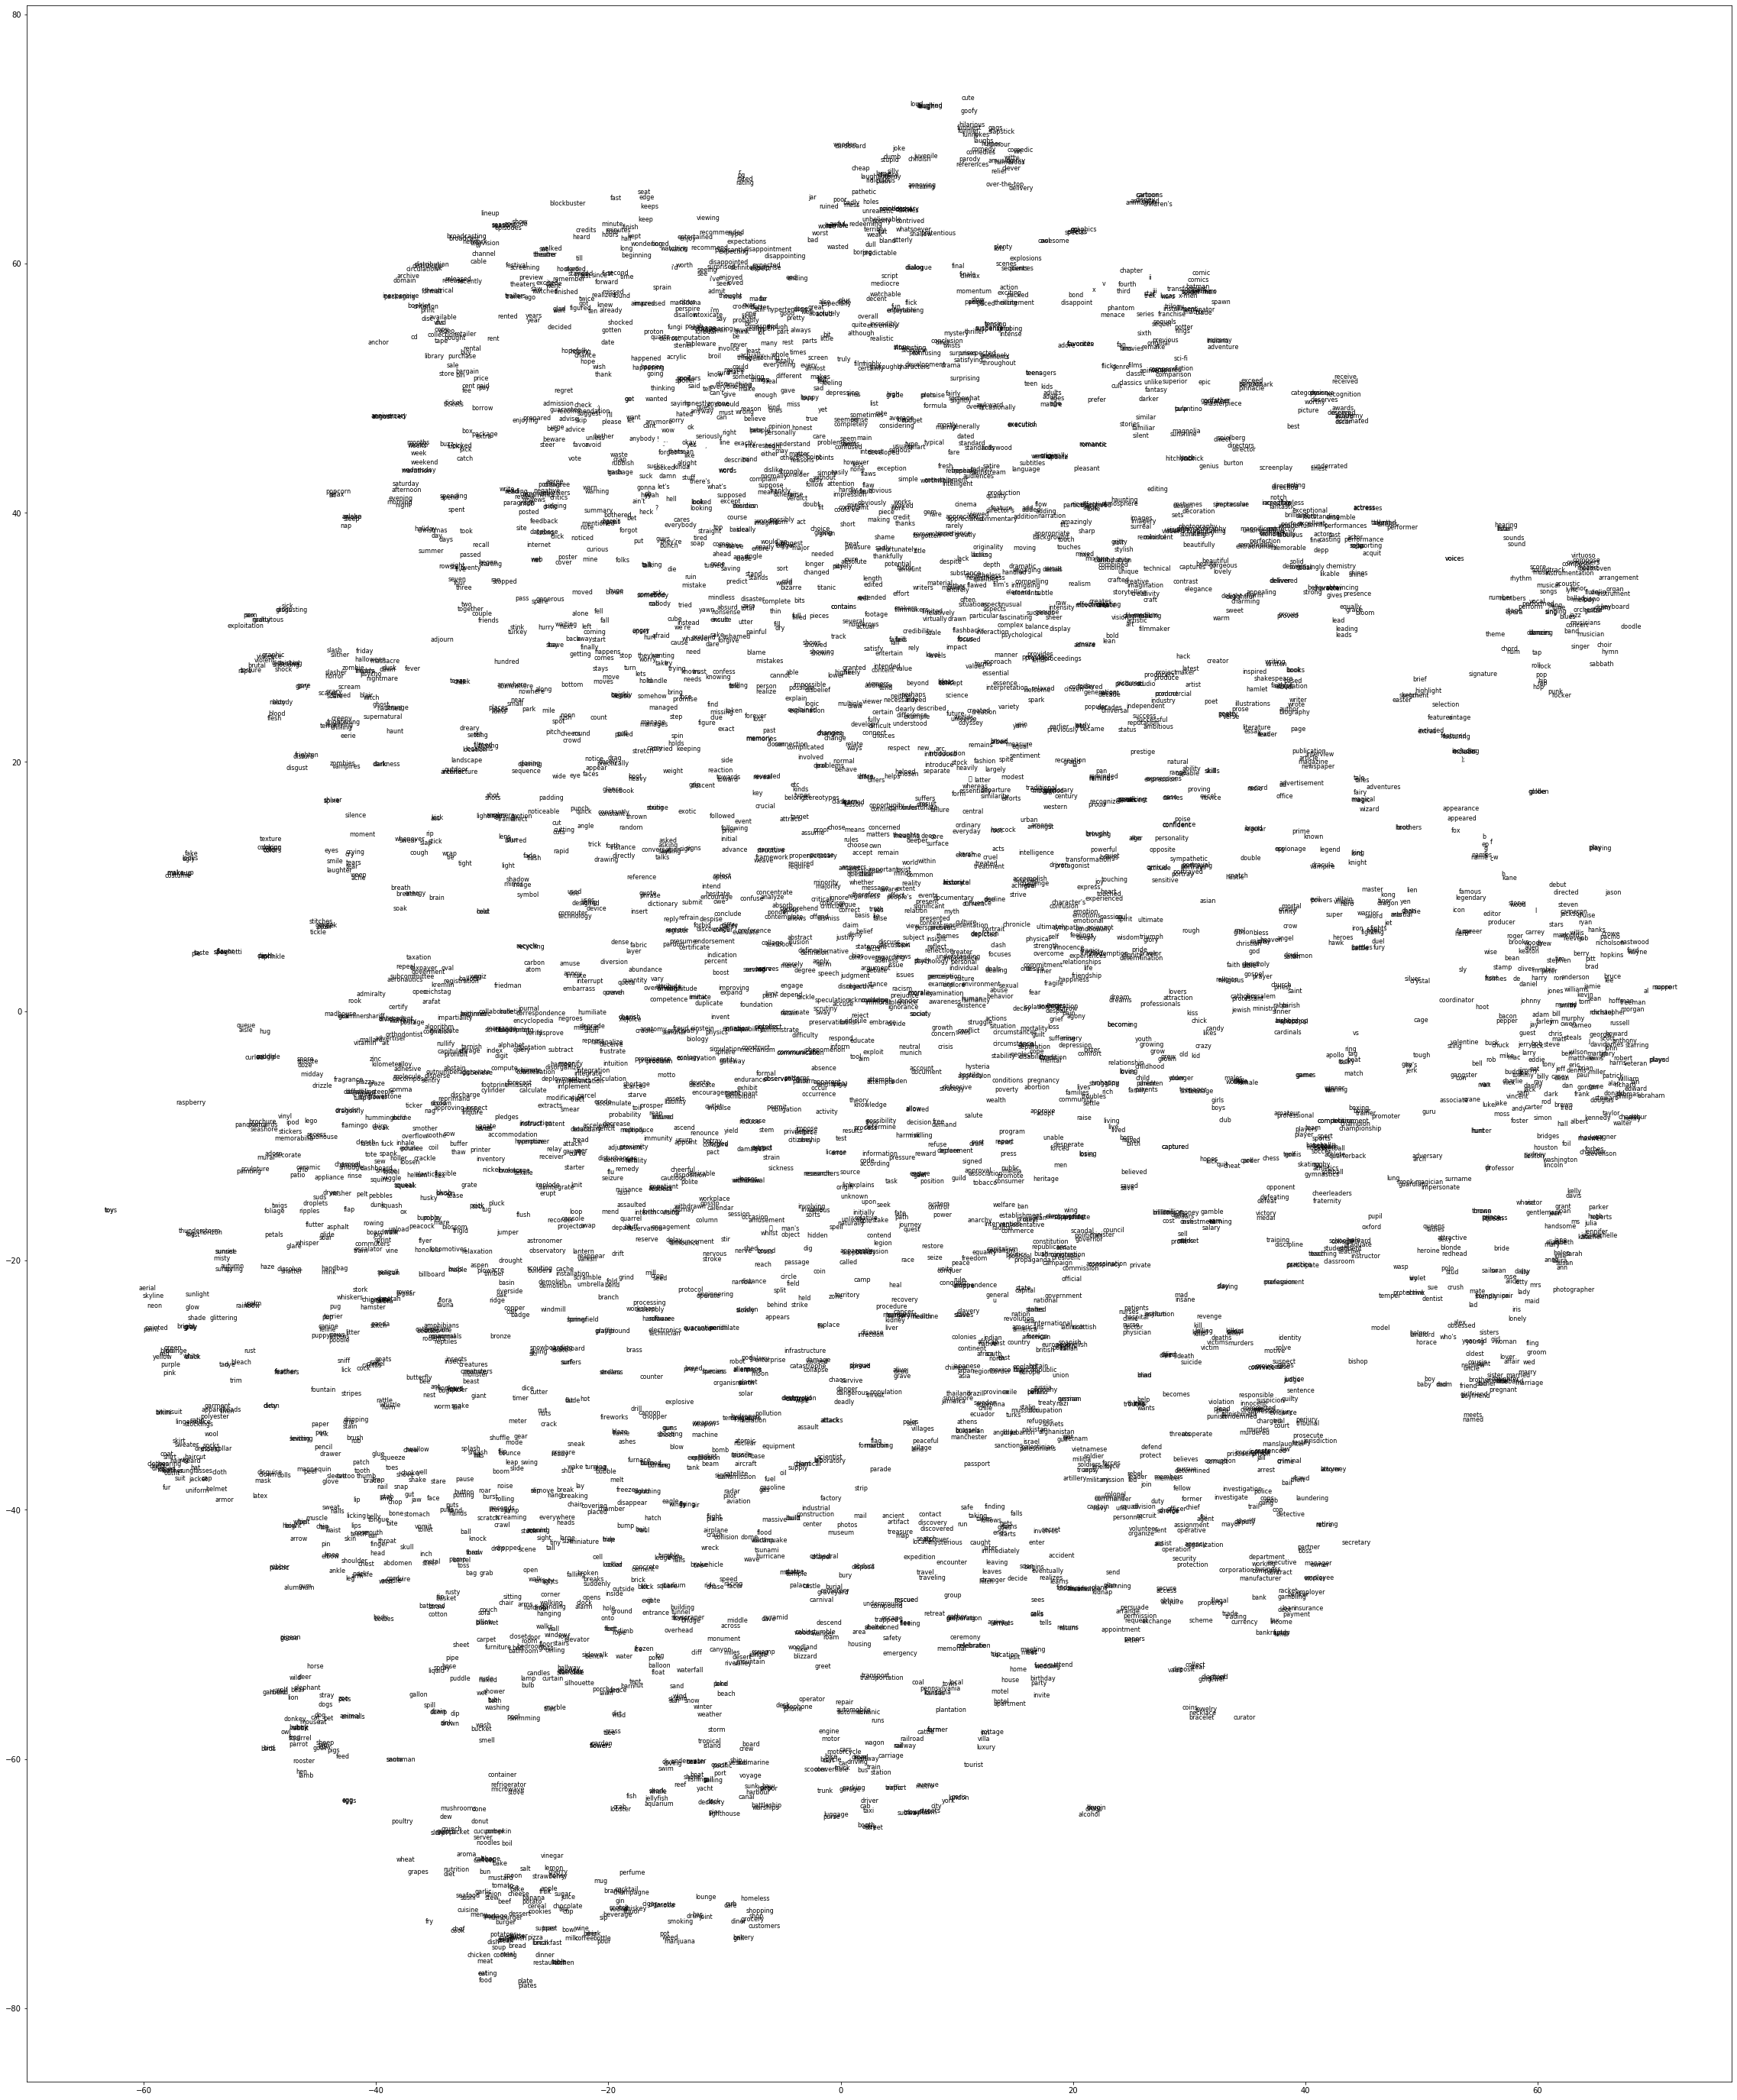

In [54]:
vsm.tsne_viz(imdb20_pmi)

---

# Exploratory exercises

These are largely meant to give you a feel for the material, but some of them could lead to projects and help you with future work for the course. These are not for credit.

## First Exercise

1. Recall that there are two versions each of the IMDB and Gigaword matrices: one with window size 5 and counts scaled as $1/d$ where $d$ is the distance from the target word; and one with a window size of 20 and no scaling of the values. Using `vsm.neighbors` to explore, how would you describe the impact of these different designs?

In [55]:
import _pickle as pickle

with open(os.path.join(DATA_HOME, 'imdb-wordcounts.pickle'), 'rb') as f_imdb,\
    open(os.path.join(DATA_HOME, 'giga-wordcounts.pickle'), 'rb') as f_giga:
    imdb_wordcount = pickle.load(f_imdb)
    giga_wordcount = pickle.load(f_giga)

**NOTE**

The pattern we are looking for is the most common words will appear **more similar** when the window size increases. And that's because the probability of a common word to appear within a big window is higher than a small window even though it appears at the end of the window. It would still get a small number unlike the case with small window size as it will get zero.

Let's explore this hypothesis

In [56]:
vsm.neighbors('want', imdb5).head(10)

want     0.000000
.        0.901508
see      0.924973
spoil    0.929098
vomit    0.941275
e        0.942012
k        0.942953
g        0.944281
p        0.947276
j        0.948221
dtype: float64

In [57]:
vsm.neighbors('want', imdb20).head(10)

want         0.000000
.            0.155652
see          0.201654
spoil        0.212749
rent         0.218592
watch        0.219595
p            0.221485
skip         0.223137
movie        0.227051
recommend    0.229566
dtype: float64

As we can see, `vomit` was the *fifth* most similar when the window is five and `rent` is the most similar when the window is 20. So, if our hypothesis is right, then:

- the count of `rent` should be bigger than `vomit`. 
- The count of `watch`  should be bigger than `e`.
- The count of `p` should be bigger than `k`.
- The count of `skip` should be bigger than `g`.
- The count of `movie` should be bigger than `p`.
- The count of `recommend` should be bigger than `j`.


In [58]:
print( "rent count:", imdb_wordcount['rent'], "\t\tvomit count:", imdb_wordcount['vomit'] )
print( "watch count:", imdb_wordcount['watch'], "\t\te count:", imdb_wordcount['e'] )
print( "p count:", imdb_wordcount['p'], "\t\t\tk count:", imdb_wordcount['k'] )
print( "skip count:", imdb_wordcount['skip'], "\t\tg count:", imdb_wordcount['g'] )
print( "movie count:", imdb_wordcount['movie'], "\t\tp count:", imdb_wordcount['p'] )
print( "recommend count:", imdb_wordcount['recommend'], "\tj count:", imdb_wordcount['j'] )

rent count: 47548 		vomit count: 3112
watch count: 470870 		e count: 45378
p count: 23985 			k count: 17040
skip count: 12869 		g count: 23607
movie count: 3353568 		p count: 23985
recommend count: 121612 	j count: 26232


The same should be applied for gigaword as well:

In [59]:
vsm.neighbors('want', giga5).head()

want    0.000000
.       0.887500
</p>    0.924851
et      0.929283
n       0.929536
dtype: float64

In [60]:
vsm.neighbors('want', giga20).head()

want    0.000000
.       0.113666
</p>    0.140479
said    0.142198
<p>     0.143202
dtype: float64

Most of the following cases should be valid:

- the count of `said` should be bigger than `et`. 
- The count of `<p>`  should be bigger than `n`.

In [61]:
print( "said count:", giga_wordcount['said'], "\t\tet count:", giga_wordcount['et'] )
print( "<p> count:", giga_wordcount['<p>'], "\t\tn count:", giga_wordcount['n'] )

said count: 17156870 		et count: 88465
<p> count: 56677463 		n count: 1116252


## Second Exercise

2. IMDB and Gigaword are very different domains. Using `vsm.neighbors`, can you find cases where the dominant sense of a word is clearly different in the two domains in a way that is reflected by vector-space proximity?

In [62]:
from tqdm import tqdm_notebook as tqdm
# from tqdm import tqdm

# find cases where the neighbors of IMDB is very different than GIGA
def find_cases(imdb_df, giga_df, maxlength=1):
    """
    This function is used to return the cases where the 10 most similar words 
    are compeletely different in IMDB than Gigaword
    Args:
        imdb_df (pandas.DataFrame): the IMDB dataframe
        giga_df (pandas.DataFrame): the Gigaword dataframe
        maxlength (int): the maximum cases to find (default is one)
    Returns:
        cases (list[str])
    """
    cases = []
    # find common words
    common_words = set(imdb_df.keys().values.tolist()).intersection(set(giga_df.keys().values.tolist()))
    # find the special cases
    for word in tqdm(common_words, desc="Searching"):
        imdb_word_neighbors = set(vsm.neighbors(word, imdb_df).head(11)[1:])
        giga_word_neighbors = set(vsm.neighbors(word, giga_df).head(11)[1:])
        if len(imdb_word_neighbors.intersection(giga_word_neighbors)) == 0:
            cases.append(word)
        # check maximum length
        if len(cases) == maxlength:
            break
    return cases

In [63]:
cases = find_cases(imdb5, giga5, 10)
print("Found %d cases" %len(cases))
print(cases)

Found 10 cases
['examiner', 'high', 'squint', 'dunk', 'path', 'jar', 'wet', 'hill', 'sixth', 'bright']


In [64]:
vsm.neighbors('high', imdb5).head(20)

high            0.000000
school          0.705095
noon            0.727840
hopes           0.843236
expectations    0.868291
brow            0.874720
.               0.893401
gear            0.928261
e               0.936525
k               0.937988
g               0.939060
p               0.942900
j               0.943507
l               0.945496
anxiety         0.946329
tolerance       0.946808
ms              0.948189
h               0.950271
v               0.950334
mr              0.950348
dtype: float64

In [65]:
vsm.neighbors('high', giga5).head(20)

high            0.000000
school          0.786256
.               0.863258
thunderstorm    0.866385
commissioner    0.894149
n               0.907400
</p>            0.910314
et              0.913389
j               0.915622
u               0.919325
p               0.920454
gen             0.922172
<p>             0.922976
rep             0.925934
h               0.926029
zinc            0.926047
ms              0.926195
mrs             0.926315
jr              0.927476
gov             0.927805
dtype: float64

## Third Exercise

3. We saw that euclidean distance favors raw frequencies. Find words in the matrix `imdb20` that help make this point: a pair that are semantically unrelated but close according to `vsm.euclidean`, and a pair that are semantically related by far apart according to `vsm.euclidean`.

In [66]:
vsm.neighbors('good', imdb20, distfunc=vsm.euclidean).head()

good      0.000000e+00
really    1.709370e+06
great     1.746426e+06
well      1.757869e+06
story     1.760839e+06
dtype: float64

In [67]:
print("Distance between 'good' and 'story':")
print(vsm.euclidean(imdb20['good'], imdb20['story']))

print("Distance between 'good' and 'awesome':")
print(vsm.euclidean(imdb20['good'], imdb20['awesome']))

print()
print("Count of 'story':", imdb_wordcount['story'])
print("Count of 'awesome':", imdb_wordcount['awesome'])

Distance between 'good' and 'story':
1760839.323440671
Distance between 'good' and 'awesome':
2605474.6770314234

Count of 'story': 860737
Count of 'awesome': 58610


**Conclusion**

As we can see, the distance between 'good' and 'story' (which is semeantically unrelated) is way closer than the distance between 'good' and 'awesome' (which are semantically related). And that's becaseu the raw count of 'story' is way bigger than the count of 'aweome'!!

## Fourth Exercise

4. Run 

  ```amod = pd.read_csv(os.path.join(DATA_HOME, 'gigawordnyt-advmod-matrix.csv.gz'), index_col=0)``` 
  
  to read in an adjective $\times$ adverb matrix derived from the Gigaword corpus. Each cell contains the number of times that the modifier phrase __ADV ADJ__ appeared in Gigaword as given by dependency parses of the data. __ADJ__ is the row value and __ADV__ is the column value. Using the above techniques and measures, try to get a feel for what can be done with this matrix.

In [68]:
amod = pd.read_csv(os.path.join(DATA_HOME, 'gigawordnyt-advmod-matrix.csv.gz'), index_col=0)

In [69]:
amod.head(10)  #3000 x 3000

,when,also,just,now,more,so,even,how,where,as,...,audio-minis,worldcom,stairway,surreally,cents,obnoxiously,jordy,shoot,screamingly,stone
Word,,,,,,,,,,,,,,,,,,,,,
is,17663,21310,10853,46433,2094,8204,8388,14546,22985,2039,...,0,0,0,0,5,0,0,2,0,0
have,20657,20156,18757,31288,2162,7508,13003,4184,12573,1572,...,0,1,0,0,0,0,0,3,0,0
was,26976,10634,8253,3014,1265,4025,5644,6554,11818,1920,...,0,0,8,0,3,0,0,1,1,0
said,19695,62588,3984,4953,923,4933,6198,575,4209,608,...,0,5,0,0,0,0,1,1,0,0
much,207,145,4184,474,10079,71460,421,64794,140,46174,...,0,0,0,0,0,0,0,0,0,0
are,11546,14212,4929,23470,2418,7591,4779,7952,19832,1214,...,0,0,0,0,1,0,0,0,1,0
get,19342,4004,8474,5811,1401,2657,5930,14477,6840,718,...,0,0,0,0,2,0,0,0,0,0
do,8299,1550,7908,9899,2733,37339,2915,14474,2376,598,...,0,0,0,0,0,0,0,1,0,0
's,7811,9488,8815,13779,1371,3949,4293,1690,6281,1500,...,0,0,0,0,5,0,0,1,0,0


In [70]:
vsm.neighbors('good', amod, distfunc=vsm.euclidean).head()

Word
good             0.000000
hard         36060.534466
high         38148.039006
strong       38543.234024
different    40733.413937
dtype: float64

In [71]:
vsm.neighbors('good', amod, distfunc=vsm.cosine).head()

Word
good      0.000000
tough     0.083685
slim      0.120531
funny     0.128068
strong    0.129393
dtype: float64

In [72]:
vsm.neighbors('good', amod, distfunc=vsm.jaccard).head()

Word
good    0.000000
hard    0.654188
well    0.699463
high    0.709477
bad     0.719611
dtype: float64

## Fifth Exercise

5. [Turney and Pantel (2010)](http://www.jair.org/media/2934/live-2934-4846-jair.pdf), p. 158, propose a "contextual discounting" extension of PMI to try to address its bias for low-frequency events. Extend `vsm.pmi` so that the user has the option of performing this discounting with the keyword argument `discounting=True`. 

The equation that we need to implement can be shown in the following image:

![](docs/contextual_discounting.jpg)

In [73]:
def new_pmi(df, discounting=True):
    df_pmi = vsm.pmi(df, positive=False)
    if discounting:
        col_total = df.sum(axis=0).sum()
        row_total = df.sum(axis=1).sum()
        numerator = df * min(row_total, col_total)
        domenerator = (df + 1) * (min(row_total, col_total) + 1)
        sigma = numerator / domenerator
        return df_pmi * sigma
    else:
        return df_pmi

In [74]:
imdb5_pmi_discounting = new_pmi(imdb5, discounting=True)
vsm.neighbors('good', imdb5_pmi_discounting).head()

good     0.000000
great    0.088283
br       0.116856
well     0.118447
bad      0.123058
dtype: float64

Now, here is the compelete comparison of different rewieghting techniques using data `imdb5`:

|Metric|dataset|closests neighbors|
|------|-------|------------------|
|euclidean|imdb5|["job", "pretty", "e", "guys"]|
|cosine|imdb5|["good", "measure", ".", "luck", "pretty"]|
|oe|imdb5|[".", "movie", "filem", "measure"]|
|PPMI|imdb5|["decent", "bad", "great", "excellent"]|
|PPMI discouting|imdb5|["great", "br", "well", "bad"]|

## Sixth Exercise

6. Use `vsm.ngram_vsm` and `character_level_rep` to create a VSM with the same vocabulary as `imdb5` but with the representations derived from trigrams, and reweight it with Positive PMI. How is this VSM different from the original?

In [75]:
imdb5_3grams = vsm.ngram_vsm(imdb5, n=3)
imdb5_3grams.shape

(3622, 5000)

In [76]:
# reweight it using PPMI
imdb5_3grams_ppmi = vsm.pmi(imdb5_3grams, positive=True)

In [77]:
superbly2 = character_level_rep("superbly", imdb5_3grams_ppmi)
superb2 = character_level_rep("superb", imdb5_3grams_ppmi)
vsm.cosine(superb2, superbly2)

/home/anwar/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


nan

I think the subwords variety isn't that rich, that's why the cosine distance is undefined!!

*THIS EXERCISE NEEDS REVISION*